# Gray-Scott Model

This notebook is originally an idea of [@gouarin](https://github.com/gouarin)

In [20]:
import sys
if sys.platform == "darwin":
    %env CC=gcc-10

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


In [22]:
%config InlineBackend.figure_format = 'retina'

The reaction-diffusion system described here involves two generic chemical species U and V, whose concentration at a given point in space is referred to by variables u and v. As the term implies, they react with each other, and they diffuse through the medium. Therefore the concentration of U and V at any given location changes with time and can differ from that at other locations.

The overall behavior of the system is described by the following formula, two equations which describe three sources of increase and decrease for each of the two chemicals:


$$
\begin{array}{l}
\displaystyle \frac{\partial u}{\partial t} = D_u \Delta u - uv^2 + F(1-u) \\
\displaystyle \frac{\partial v}{\partial t} = D_v \Delta v + uv^2 - (F+k)v
\end{array}
$$

The laplacian is computed with the following numerical scheme

$$
\Delta u_{i,j} \approx u_{i,j-1} + u_{i-1,j} -4u_{i,j} + u_{i+1, j} + u_{i, j+1}
$$

The classic Euler scheme is used to integrate the time derivative.

## Initialization

$u$ is $1$ everywhere et $v$ is $0$ in the domain except in a square zone where $v = 0.25$ and $ u = 0.5$. This square located in the center of the domain is  $[0, 1]\times[0,1]$ with a size of $0.2$.


In [23]:
def init(n):
 
    u = np.ones((n+2,n+2))
    v = np.zeros((n+2,n+2))
    
    x, y = np.meshgrid(np.linspace(0, 1, n+2), np.linspace(0, 1, n+2))

    mask = (0.4<x) & (x<0.6) & (0.4<y) & (y<0.6)
    
    u[mask] = 0.50
    v[mask] = 0.25
        
    return u, v

## Boundary conditions

We assume that the domain is periodic.


In [24]:
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

## Laplacian

In [25]:
def laplacian(u):
    """
    second order finite differences
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )

## Gray-Scott model

In [26]:
def numpy_grayscott(U, V, Du, Dv, F, k):
    
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    Lu = laplacian(U)
    Lv = laplacian(V)

    uvv = u*v*v
    u += Du*Lu - uvv + F*(1 - u)
    v += Dv*Lv + uvv - (F + k)*v

    periodic_bc(U)
    periodic_bc(V)
    
    return U, V

## Visualization

Nous utiliserons les données suivantes.

In [27]:
Du, Dv = .2, .03
F, k = 0.0545, 0.062

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

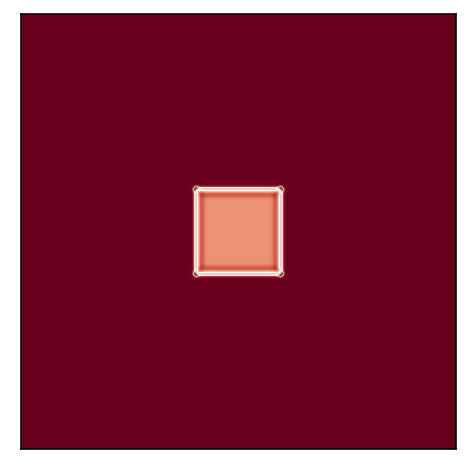

In [32]:
%%time
from tqdm.notebook import tqdm
from PIL import Image
U, V = init(300)

def create_image(grayscott):
    global U, V
    for t in range(40):
        U, V = grayscott(U, V, Du, Dv, F, k)
        V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
       # fig = pyplot.figure(figsize=(8,5))
        plt.imshow(V, cmap = cm.RdGy)
        plt.xticks([]), pyplot.yticks([]);
        plt.savefig('%d.png'%t,dpi=120)
   # return V_scaled

def create_frames(n, grayscott):

    return [create_image(grayscott) for i in tqdm(range(n))]
    
frames = create_frames(500, numpy_grayscott)

In [13]:
import imageio
import cv2 
frames_scaled = [ cv2.imread('%i.png'%i) for i in range(0,40)]
imageio.mimsave('movie.gif', frames_scaled, format='gif', fps=60)

In [11]:
from ipywidgets import interact, IntSlider


def display_sequence(iframe):
    
    return Image.fromarray(frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

NameError: name 'frames' is not defined

In [93]:
import imageio
frames_scaled = [frame for frame in frames]
imageio.mimsave('movie1.gif', frames_scaled, format='gif', fps=60)


ValueError: Image is not numeric, but AxesImage.

![grayscott](movie1.gif "grayscott")

## References

- [Reaction-Diffusion by the Gray-Scott Model: Pearson's Parametrization](https://mrob.com/pub/comp/xmorphia/)

## Cython

[Program by Hyry](https://stackoverflow.com/questions/26823312/numba-or-cython-acceleration-in-reaction-diffusion-algorithm)

In [24]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [25]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

cpdef cython_grayscott(np.ndarray[double, ndim=2] U, np.ndarray[double, ndim=2] V, double Du, double Dv, double F, double k):
   
    cdef np.ndarray u = U[1:-1,1:-1]
    cdef np.ndarray v = V[1:-1,1:-1]

    cdef np.ndarray Lu = np.zeros_like(u)
    cdef np.ndarray Lv = np.zeros_like(v)
    cdef Py_ssize_t i, c, r, r1, c1, r2, c2
    cdef double uvv

    cdef double[:, ::1] bU = U
    cdef double[:, ::1] bV = V
    cdef double[:, ::1] bLu = Lu
    cdef double[:, ::1] bLv = Lv
    
    n = np.shape(U)[0]-2

    for r in range(n):
        r1 = r + 1
        r2 = r + 2
        for c in range(n):
            c1 = c + 1
            c2 = c + 2
            bLu[r,c] = bU[r1,c2] + bU[r1,c] + bU[r2,c1] + bU[r,c1] - 4*bU[r1,c1]
            bLv[r,c] = bV[r1,c2] + bV[r1,c] + bV[r2,c1] + bV[r,c1] - 4*bV[r1,c1]

    for r in range(n):
        r1 = r + 1
        for c in range(n):
            c1 = c + 1
            uvv = bU[r1,c1]*bV[r1,c1]*bV[r1,c1]
            bU[r1,c1] += Du*bLu[r,c] - uvv + F*(1 - bU[r1,c1])
            bV[r1,c1] += Dv*bLv[r,c] + uvv - (F + k)*bV[r1,c1]

    return U, V

In [26]:
U, V = init(300)
frames = create_frames(500, cython_grayscott)

TypeError: create_frames() takes 1 positional argument but 2 were given

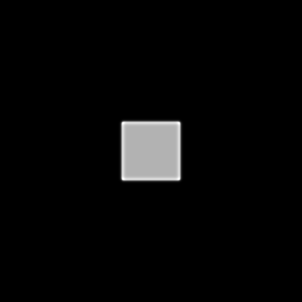

<function __main__.display_sequence(iframe)>

In [62]:

interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

In [33]:
%load_ext fortranmagic

In [34]:
%%fortran     
subroutine fortran_grayscott( U, V, Du, Dv, F, k)

    real(8), intent(in) :: Du, Dv, F, k
    real(8) :: U(:,:)
    real(8) :: V(:,:)
    real(8), allocatable :: Lu(:,:), Lv(:,:)
    integer :: n, c, r, r1, c1, r2, c2
    real(8) :: uvv

    n = size(U,1)
   
    Lu = U(2:n-1,2:n-1)
    Lv = V(2:n-1,2:n-1)

    do c = 1, n-2
        c1 = c + 1
        c2 = c + 2
        do r = 1, n-2
            r1 = r + 1
            r2 = r + 2 
            Lu(r,c) = U(r1,c2) + U(r1,c) + U(r2,c1) + U(r,c1) - 4*U(r1,c1)
            Lv(r,c) = V(r1,c2) + V(r1,c) + V(r2,c1) + V(r,c1) - 4*V(r1,c1)
        end do
    end do

    do c = 1, n-2
        c1 = c + 1
        do r = 1, n-2
            r1 = r + 1     
            uvv = U(r1,c1)*V(r1,c1)*V(r1,c1)
            U(r1,c1) = U(r1, c1) + Du*Lu(r,c) - uvv + F*(1 - U(r1,c1))
            V(r1,c1) = V(r1, c1) + Dv*Lv(r,c) + uvv - (F + k)*V(r1,c1)
        end do
    end do

end subroutine fortran_grayscott

In [42]:
U, V = init(300)
U = np.asfortranarray(U)
V = np.asfortranarray(V)
def create_image():
    global U, V
    for t in range(40):
        fortran_grayscott(U, V, Du, Dv, F, k)

    V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
    
    return V_scaled

def create_frames(n):

    return [create_image() for i in tqdm(range(n))]
    
frames = create_frames(500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
for i in range(len(frames)):
       # fig = pyplot.figure(figsize=(8,5))
        plt.imshow(frames[i], cmap = cm.RdGy)
        plt.xticks([]), pyplot.yticks([]);
        plt.savefig('%d.png'%i,dpi=120)
   # return V_scaled

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2c7ccc1160> (for post_execute):


KeyboardInterrupt: 

In [46]:
import imageio
import cv2 
frames_scaled = [ cv2.imread('%i.png'%i) for i in range(0,350)]
imageio.mimsave('movie.gif', frames_scaled, format='gif', fps=60)

In [20]:
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

<function __main__.display_sequence(iframe)>

In [83]:
U, V = init(300)
%timeit numpy_grayscott(U, V, Du, Dv, F, k)

1.96 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [84]:
U, V = init(300)
%timeit cython_grayscott(U, V, Du, Dv, F, k)

1.33 ms ± 3.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [107]:
U, V = init(300)
U = np.asfortranarray(U)
V = np.asfortranarray(V)
%timeit fortran_grayscott(U, V, Du, Dv, F, k)

274 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
